In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"



In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
num_epochs = 50
batch_size = 40
learning_rate = 0.001
classes = ('plane', 'car' , 'bird',
    'cat', 'deer', 'dog',
    'frog', 'horse', 'ship', 'truck')

cuda


In [3]:
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize( 
       (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010) 
    )
])
train_dataset = torchvision.datasets.CIFAR10(
    root= './data', train = True,
    download =True, transform = transform)
test_dataset = torchvision.datasets.CIFAR10(
    root= './data', train = False,
    download =True, transform = transform)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset
    , batch_size = batch_size
    , shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset
    , batch_size = batch_size
    , shuffle = True)
n_total_step = len(train_loader)
print(n_total_step)


1250


In [10]:
model = torch.load("cifar-10_2.pth")
model = model.to(device)
model.eval()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9,weight_decay=5e-4)


In [16]:
from tqdm import tqdm

def normalize_max1(w):
    for i in range(len(w)):
        w[i] = w[i] / torch.max(abs(w[i]))
    return w

to_gaussian = lambda arr, mean = 1, std = 1: ((arr - torch.mean(arr))/ (torch.std(arr) + 0.00001)) * std + mean

softmax = torch.nn.Softmax(dim=1)
softmax2d = lambda b: softmax(torch.flatten(b, start_dim = 1)).reshape(b.shape)
f2 = lambda w, _=None: softmax2d(normalize_max1(-w)) * len(w[0])

def normalize(img):
    img = img- torch.min(img)
    img /= (torch.max(img) + 0.01)
    img = img* 255
    return img.int()

def change_format(img):
    return torch.cat((img[2].unsqueeze(-1), img[1].unsqueeze(-1), img[0].unsqueeze(-1)), dim=-1)

def image_unnormalize(img):
    img = normalize(img)
    img = change_format(img).cpu().detach().numpy().reshape(224,224,3)
    return img




In [45]:
from PIL import Image


In [118]:
correct_before, correct_after, all = 0,0, 0
import pickle

write_data = []

for idx, batch in enumerate(tqdm(test_loader)):
    img , label = batch[0].cuda(), batch[1].cuda()

    img.requires_grad = True
    img.retain_grad = True
    
    output = model(img)

    loss = criterion(output, label)
    loss.backward()
    optimizer.zero_grad()

    img_lrp = (img*img.grad).clone()
    img_lrp = f2(img_lrp)
    
    with torch.no_grad():
        for i in range(len(img_lrp)):
            img_lrp[i] = to_gaussian(img_lrp[i], std = 0.1)

        img_lrp = img*img_lrp # img_lrp가 음수값인것 지움
        softlabel = model(img_lrp)
    
    for it in range(len(img)):
        write_pickle = {
            "label" : label[it].item(),
            "softlabel" : softlabel[it].cpu().numpy(),
            "img" : img[it].detach().cpu().numpy(),
            "lrp_img": img_lrp[it].detach().cpu().numpy()
        }
        write_data.append(write_pickle)
        
        


100%|██████████| 250/250 [01:17<00:00,  3.23it/s]


In [119]:
!mkdir MnistLRP_TEST

In [120]:
for idx, d in enumerate(tqdm(write_data)):
    with open("MnistLRP_TEST/" + str(idx).zfill(6) + ".pickle", "wb") as f:
        pickle.dump(d, f)

    

100%|██████████| 10000/10000 [00:10<00:00, 998.56it/s]


In [61]:
Image.fromarray(image_unnormalize(img[it]))

TypeError: Cannot handle this data type: (1, 1, 224), <i4

In [71]:
def normalize(img):
    img = img- torch.min(img)
    img /= (torch.max(img) + 0.01)
    img = img* 255
    return img.int()

def change_format(img):
    return torch.cat((img[2].unsqueeze(-1), img[1].unsqueeze(-1), img[0].unsqueeze(-1)), dim=-1)

def image_unnormalize(img):
    img = normalize(img)
    img = change_format(img).cpu().detach().numpy().reshape(224,224,3)
    return img


In [30]:
from matplotlib import pyplot as plt
normalize(img[0]).shape

torch.Size([3, 224, 224])

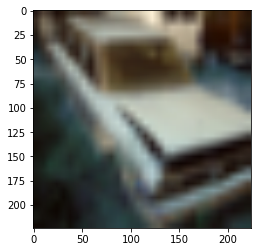

In [40]:

plt.imshow(image_unnormalize(img[2]))
